In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from basic_utils import *
from pricing import *

pd.options.display.float_format = '{:,.3f}'.format

Loading config.json
Loading file quote/csv/2019-02-22
Loading file summary-categories/assetProfile


In [2]:
symbol = '^VIX'
# excl_list = ['ORBK']
# profile.drop(profile[profile.symbol.isin(excl_list)].index, inplace=True)

### Get universe pricing

In [3]:
# TAKES LONG: all pricing loaded, should do only once
symbols_list = config['benchmarks'] + config['sectors'] + config['risk']
%time px_set = get_mults_pricing(symbols_list, freq, 'close')

Retrieved pricing for SPY
Retrieved pricing for QQQ
Retrieved pricing for DIA
Retrieved pricing for IWM
Retrieved pricing for IJR
Retrieved pricing for IJH
Retrieved pricing for FXI
Retrieved pricing for EEM
Retrieved pricing for ^DJI
Retrieved pricing for ^IXIC
Retrieved pricing for ^GSPC
Retrieved pricing for ^RUT
Retrieved pricing for XLB
Retrieved pricing for XLC
Retrieved pricing for XLE
Retrieved pricing for XLF
Retrieved pricing for XLI
Retrieved pricing for XLK
Retrieved pricing for XLP
Retrieved pricing for XLRE
Retrieved pricing for XLU
Retrieved pricing for XLV
Retrieved pricing for XLY
Retrieved pricing for ^VIX
CPU times: user 540 ms, sys: 66.5 ms, total: 607 ms
Wall time: 6.63 s


### Full universe dataset creation

### In one shot

### Step-by-step

In [6]:
# All daily pricing is downloaded for 10 years by default
get_pricing('^VIX', '1d', '30y');
get_pricing('^GSPC', '1d', '30y');

Getting pricing interval of ^VIX interval: 1d, range: 30y
Getting pricing interval of ^GSPC interval: 1d, range: 30y


In [23]:
# Retrieves historical pricing
secpx = get_symbol_pricing('^VIX', freq)
secpx.set_index(secpx.index.astype(np.datetime64), inplace=True)

SPY = get_symbol_pricing('^GSPC', freq) # SPY pricing
SPY.set_index(SPY.index.astype(np.datetime64), inplace=True)
SPY_close = SPY['close']
SPY_pct_chg = SPY_close.pct_change()

In [24]:
# historical returns for 1, 3, and 6 months
secpx['spyChg1d'] = SPY_close.pct_change()
secpx['spyChg1m'] = SPY_close.pct_change(periods=20)
secpx['spyChg3m'] = SPY_close.pct_change(periods=60)
secpx['spyChg6m'] = SPY_close.pct_change(periods=180)

# Forward returns, 1w, 1m, 3m
SPY_close.pct_change(5).shift(-5)
secpx['fwdChg1w'] = SPY_close.pct_change(5).shift(-5)
secpx['fwdChg1m'] = SPY_close.pct_change(20).shift(-20)
secpx['fwdChg3m'] = SPY_close.pct_change(60).shift(-60)

In [25]:
closepx = secpx['close']
closepx_1d_shift = closepx.shift(1)
pct_chg = closepx.pct_change()

# gap analysis, open, close, previous close
secpx['openGap'] = closepx - closepx_1d_shift
secpx['openGapPerc'] = secpx['openGap'] / closepx_1d_shift
secpx['coDelta'] = secpx['close'] - secpx['open']
secpx['coDeltaPerc'] = secpx['coDelta'] - secpx['open']
secpx['hlDelta'] = secpx['high'] - secpx['low']
secpx['hlDeltaPerc'] = secpx['coDelta'] - secpx['open']
secpx['pxChange'] = closepx.pct_change()

In [26]:
# apply 20sma upper and lower std bands, # stds from file
secpx = apply_std_boundaries(secpx, 'close', 20, 2) # 1 month
secpx = apply_std_boundaries(secpx, 'close', 252*5, 2) # 5 years

# how many of stds from 0?
secpx['pct_chg_std'] = pct_chg.apply(sign_compare, args=(pct_chg.std(),))

# % of moving averages
secpx['pxPerc1mStdUB'] = closepx / secpx['sma20ub']
secpx['pxPerc1mStdLB'] = closepx / secpx['sma20lb']
secpx['pxPerc5yrStdUB'] = closepx / secpx['sma1260ub']
secpx['pxPerc5yrStdLB'] = closepx / secpx['sma1260lb']

# Price momentum transformations
secpx['pxMa20'] = closepx.rolling(20).mean()
secpx['pxMa50'] = closepx.rolling(50).mean()
secpx['pxMa200'] = closepx.rolling(200).mean()
secpx['pxMa5yr'] = closepx.rolling(252*5).mean()

# closing pricing as % of 20, 50 and 200 day and 5 year average
secpx['pxPercMa20'] = closepx / secpx['pxMa20']
secpx['pxPercMa50'] = closepx / secpx['pxMa50']
secpx['pxPercMa200'] = closepx / secpx['pxMa200']
secpx['pxPercMa5yr'] = closepx / secpx['pxMa5yr']

In [27]:
# historical percentage change
secpx['chg1w'] = closepx.pct_change(periods=5)
secpx['chg1m'] = closepx.pct_change(periods=20)
secpx['chg3m'] = closepx.pct_change(periods=60)
secpx['chg6m'] = closepx.pct_change(periods=180)

secpx['cumCount20'] = secpx['openGap'].apply(pos_neg).rolling(20).sum()
secpx['cumCount60'] = secpx['openGap'].apply(pos_neg).rolling(60).sum()
secpx['cumCount200'] = secpx['openGap'].apply(pos_neg).rolling(200).sum()

In [28]:
# rolling SPY correlations
secpx['spyRollCorr5'] = closepx.pct_change().rolling(5).corr(SPY_pct_chg)
secpx['spyRollCorr20'] = closepx.pct_change().rolling(20).corr(SPY_pct_chg)
secpx['spyRollCorr60'] = closepx.pct_change().rolling(60).corr(SPY_pct_chg)
secpx['spyRollCorr200'] = closepx.pct_change().rolling(200).corr(SPY_pct_chg)

# apply seasonality, mean return of curr month plus next two
secpx['month'] = secpx.index.month
ss_df, ss_pos = get_pct_chg_seasonality(SPY_close, 'M')
secpx['fwdSSRetSPY'] = secpx.loc[:].month.apply(fwd_ss_ret, args=(ss_df, ss_pos,))
ss_df, ss_pos = get_pct_chg_seasonality(closepx, 'M')
secpx['fwdSSRetVIX'] = secpx.loc[:].month.apply(fwd_ss_ret, args=(ss_df, ss_pos,))

# drop month column not necessary
secpx.drop(columns=['month'], inplace=True)

In [29]:
# quick overview on statistically significnat pct moves
# pd.value_counts(secpx['pct_chg_std']).sort_index()
# secpx['pct_chg_std'][secpx['pct_chg_std'] > 15]
# secpx.loc['2018-02',:]

In [30]:
secpx.describe().T

,count,mean,std,min,25%,50%,75%,max
high,"7,343.000",20.068,8.232,9.310,14.240,17.980,23.540,89.530
low,"7,343.000",18.655,7.437,8.560,13.160,16.840,22.060,72.760
open,"7,343.000",19.335,7.863,9.010,13.630,17.440,22.800,80.740
close,"7,343.000",19.269,7.794,9.140,13.610,17.410,22.660,80.860
volume,"7,343.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000
spyChg1d,"7,343.000",0.000,0.011,-0.090,-0.004,0.001,0.006,0.116
spyChg1m,"7,343.000",0.007,0.042,-0.282,-0.015,0.011,0.031,0.235
spyChg3m,"7,343.000",0.019,0.071,-0.413,-0.014,0.026,0.061,0.382
spyChg6m,"7,343.000",0.061,0.128,-0.496,0.006,0.073,0.139,0.626
fwdChg1w,"7,338.000",0.002,0.023,-0.183,-0.010,0.003,0.014,0.191


In [31]:
# first 5 cols are price and volume
secpx.columns[:5], secpx.columns[5:] # all columns

(Index(['high', 'low', 'open', 'close', 'volume'], dtype='object'),
 Index(['spyChg1d', 'spyChg1m', 'spyChg3m', 'spyChg6m', 'fwdChg1w', 'fwdChg1m',
        'fwdChg3m', 'openGap', 'openGapPerc', 'coDelta', 'coDeltaPerc',
        'hlDelta', 'hlDeltaPerc', 'pxChange', 'sma20', 'sma20ub', 'sma20lb',
        'sma20bw', 'sma1260', 'sma1260ub', 'sma1260lb', 'sma1260bw',
        'pct_chg_std', 'pxPerc1mStdUB', 'pxPerc1mStdLB', 'pxPerc5yrStdUB',
        'pxPerc5yrStdLB', 'pxMa20', 'pxMa50', 'pxMa200', 'pxMa5yr',
        'pxPercMa20', 'pxPercMa50', 'pxPercMa200', 'pxPercMa5yr', 'chg1w',
        'chg1m', 'chg3m', 'chg6m', 'cumCount20', 'cumCount60', 'cumCount200',
        'spyRollCorr5', 'spyRollCorr20', 'spyRollCorr60', 'spyRollCorr200',
        'fwdSSRetSPY', 'fwdSSRetVIX'],
       dtype='object'))

In [32]:
ml_ds_cols = secpx.columns[5:]
ml_ds_df = secpx[ml_ds_cols].copy()

In [33]:
ds_name = 'ds_macro_vix_'
update_fmt = 'Added {} to {} dataset'

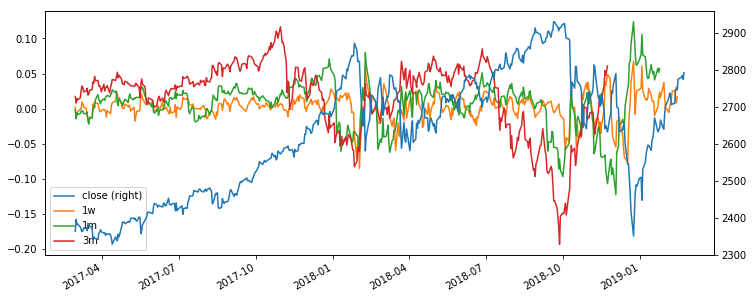

In [34]:
rets = pd.DataFrame(SPY_close.iloc[-500:].copy())
px = rets['close']
rets['1w'] = px.pct_change(5).shift(-5)
rets['1m'] = px.pct_change(20).shift(-20)
rets['3m'] = px.pct_change(60).shift(-60)
rets.plot(secondary_y='close', figsize=(12,5));

In [35]:
# Discretize forward returns into consistent classes
class_cols = ['fwdChg1w', 'fwdChg1m', 'fwdChg3m']
cut_range = [-1, -0.05, .0, .02, .09, 1.]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
for c in class_cols: 
    ml_ds_df[c] = pd.cut(ml_ds_df[c], cut_range, labels=fwd_ret_labels)

In [427]:
# Split into different datasets with Y at the end, save in S3
Xs = [x for x in ml_ds_cols if x not in class_cols]
for y in class_cols:
    ds_cols = Xs + [y] # join Xs and Y
    fname = ds_name + y # dataset name
    # drop nas and shuffle the data    
    ml_ds_df_y = ml_ds_df[ds_cols].dropna().sample(frac=1)
    csv_store(ml_ds_df_y, 'training/', csv_ext.format(fname))
    print(update_fmt.format(len(ml_ds_df_y), fname))

Saved training/ds_macro_vix_fwdChg1w.csv
Added 6078 to ds_macro_vix_fwdChg1w dataset
Saved training/ds_macro_vix_fwdChg1m.csv
Added 6063 to ds_macro_vix_fwdChg1m dataset
Saved training/ds_macro_vix_fwdChg3m.csv
Added 6023 to ds_macro_vix_fwdChg3m dataset


In [36]:
ml_ds_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7343 entries, 1990-01-02 to 2019-02-22
Data columns (total 48 columns):
spyChg1d          7343 non-null float64
spyChg1m          7343 non-null float64
spyChg3m          7343 non-null float64
spyChg6m          7343 non-null float64
fwdChg1w          7338 non-null category
fwdChg1m          7323 non-null category
fwdChg3m          7283 non-null category
openGap           7342 non-null float64
openGapPerc       7342 non-null float64
coDelta           7343 non-null float64
coDeltaPerc       7343 non-null float64
hlDelta           7343 non-null float64
hlDeltaPerc       7343 non-null float64
pxChange          7342 non-null float64
sma20             7324 non-null float64
sma20ub           7324 non-null float64
sma20lb           7324 non-null float64
sma20bw           7324 non-null float64
sma1260           6084 non-null float64
sma1260ub         6084 non-null float64
sma1260lb         6084 non-null float64
sma1260bw         6084 non-null 

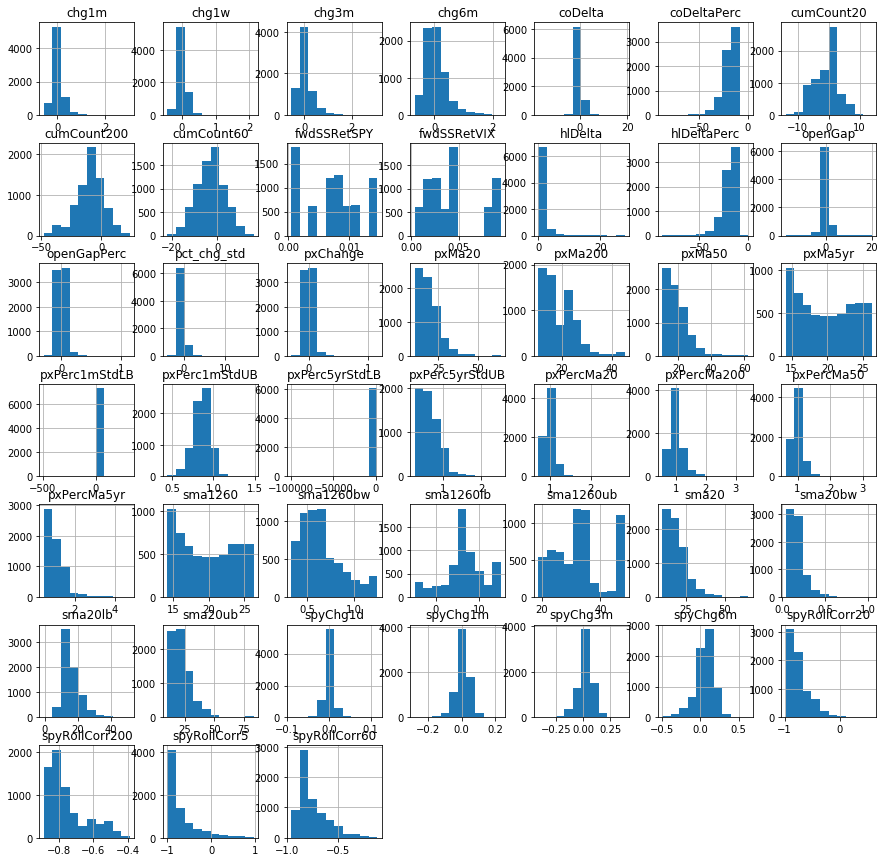

In [37]:
ml_ds_df.hist(figsize=(15,15));